# Loading Dependencies

In [1]:
import warnings
import pkg_resources
warnings.filterwarnings('ignore')
pkg_resources.require("scipy==1.8")
pkg_resources.require("networkx==2.7")
import scipy
import networkx as nx

In [2]:
import pickle
from src.models import *
from src.utils import *
from src.utils_data import *
import multiprocess
import argparse
import time
import logging
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import random_split
import numpy as np
import networkx as nx
import scipy
import pickle
from functools import partial
import random
from random import randint
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
import seaborn as sns
import math
import itertools
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd

In [3]:
def nCr(n,m):
    return int(math.factorial(n)/(math.factorial(m)*math.factorial(n-m)))

# Loading the Model

In [9]:
base_size = 10
num_unroll = 20

In [10]:
n_hid = 32
n_latent = 5
n_nodeFeat = 1
n_graphFeat = 16

net = learn2graph(num_unroll, base_size, n_hid, n_latent, n_nodeFeat, n_graphFeat).to(device)

In [11]:
net.load_state_dict(torch.load('Saved Models/RL2G_{}_unroll{}.pt'.format(base_size, num_unroll), map_location=torch.device('cpu'))['net_state_dict'])
net.eval()

learn2graph(
  (vae): TopoDiffVAE(
    (enc): GraphEnc(
      (conv1): GraphConvLayer()
      (conv2): GraphConvLayer()
      (fc1): Linear(in_features=64, out_features=32, bias=True)
      (fc2): Linear(in_features=32, out_features=16, bias=True)
    )
    (f_mean): Sequential(
      (0): Linear(in_features=16, out_features=5, bias=True)
    )
    (f_var): Sequential(
      (0): Linear(in_features=16, out_features=5, bias=True)
    )
    (dec): Sequential(
      (0): Linear(in_features=50, out_features=60, bias=True)
      (1): Tanh()
      (2): Linear(in_features=60, out_features=45, bias=True)
    )
  )
)

# Test 1 - BA 25

In [109]:
graph_size = 25

In [110]:
weight = 'gaussian'
main_data = generate_BA_parallel(num_samples=10,
                            num_signals=4000,
                            num_nodes=graph_size,
                            graph_hyper={'m':4},
                            weighted=weight,
                            weight_scale=True)

index = 6

***one data sample***

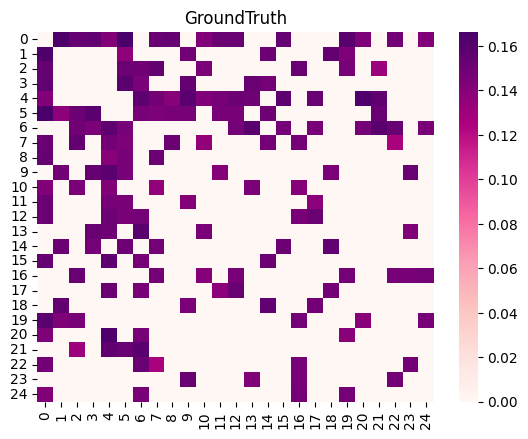

In [111]:
plt.figure()
sns.heatmap(main_data['W'][index].toarray(), cmap = 'RdPu')
plt.title('GroundTruth')
plt.show()

In [112]:
print('Number of Combinations {} out of {}:'.format(base_size, graph_size))
print(nCr(graph_size, base_size))

Number of Combinations 10 out of 25:
3268760


## K-combination Method

In [4]:
def k_combinations(n, m, k):
    k = min(k, nCr(n-2, m-2))
    combinations = []
    for i in range(n):
        for j in range(i+1,n):
            for _ in range(k):
                combinations.append(sorted([i,j]+random.sample(list(set(range(n)).difference({i,j})),m-2)))
    return combinations

In [114]:
k = 5
print('Number of {}-Combinations {} out of {}:'.format(k, base_size, graph_size))
print(graph_size*(graph_size-1)//2*k)

Number of 5-Combinations 10 out of 25:
1500


In [115]:
threshold = 0.16
adjacency_matrix = [ [0]*graph_size for _ in range(graph_size) ]
count_matrix = [ [0]*graph_size for _ in range(graph_size) ]
combinations = k_combinations(graph_size, base_size, k)
z_squareform = squareform(main_data['z'][index])

for comb in combinations:
    mini_combinations = list(itertools.combinations(comb, 2))
    new_z = []
    for minicomb in mini_combinations:
        new_z.append(z_squareform[minicomb[0]][minicomb[1]])
        count_matrix[minicomb[0]][minicomb[1]] += 1
        count_matrix[minicomb[1]][minicomb[0]] += 1

    new_z_tt = torch.tensor([new_z]).float().to(device)
    w_list = net.validation(new_z_tt , threshold=1e-04)
    w_pred = torch.clamp(w_list[:, - 1, :], min=0)[0].detach().cpu().numpy()

    for i, minicomb in enumerate(mini_combinations):
        adjacency_matrix[minicomb[0]][minicomb[1]] += w_pred[i]
        adjacency_matrix[minicomb[1]][minicomb[0]] += w_pred[i]

temp1 = [ [0]*graph_size for _ in range(graph_size) ]
temp2 = main_data['W'][index].toarray()

for i in range(graph_size):
    for j in range(i+1, graph_size):
        if count_matrix[i][j] is not 0:
            adjacency_matrix[i][j] /= count_matrix[i][j]
            adjacency_matrix[j][i] /= count_matrix[j][i]
        if adjacency_matrix[i][j]<threshold:
            temp1[i][j]=0
            temp1[j][i]=0
        else:
            temp1[i][j]=adjacency_matrix[i][j]
            temp1[j][i]=adjacency_matrix[j][i]

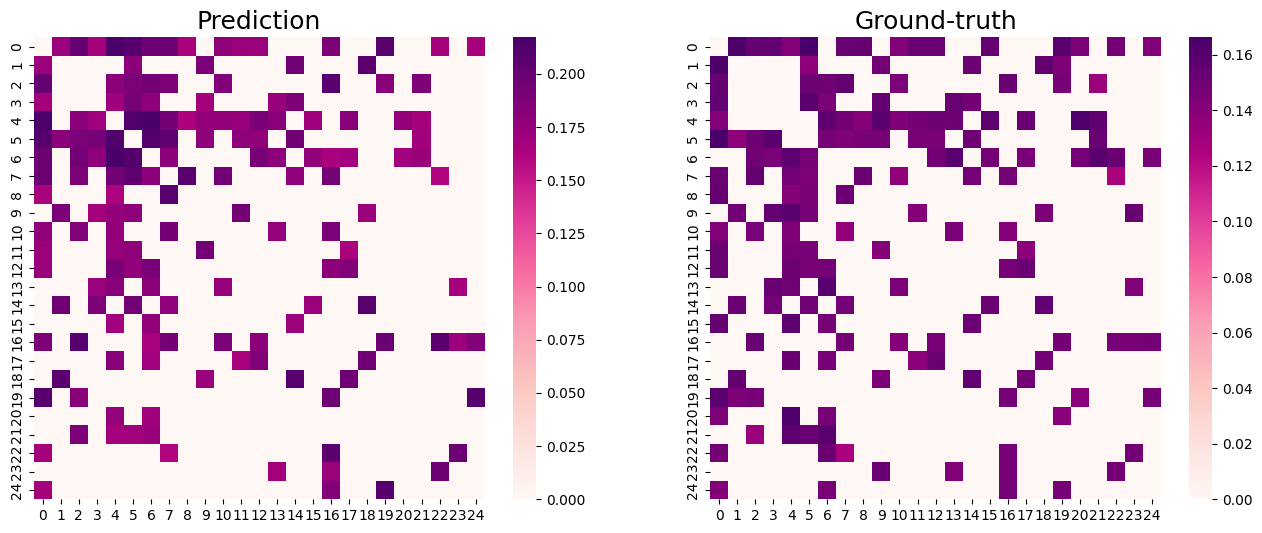

In [116]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 6))
sns.heatmap(temp1, cmap = 'RdPu',  ax=axs[0])
axs[0].set_title('Prediction', fontsize=18)
sns.heatmap(temp2, cmap = 'RdPu', ax=axs[1])
axs[1].set_title('Ground-truth', fontsize=18)
plt.show()

## Binarization

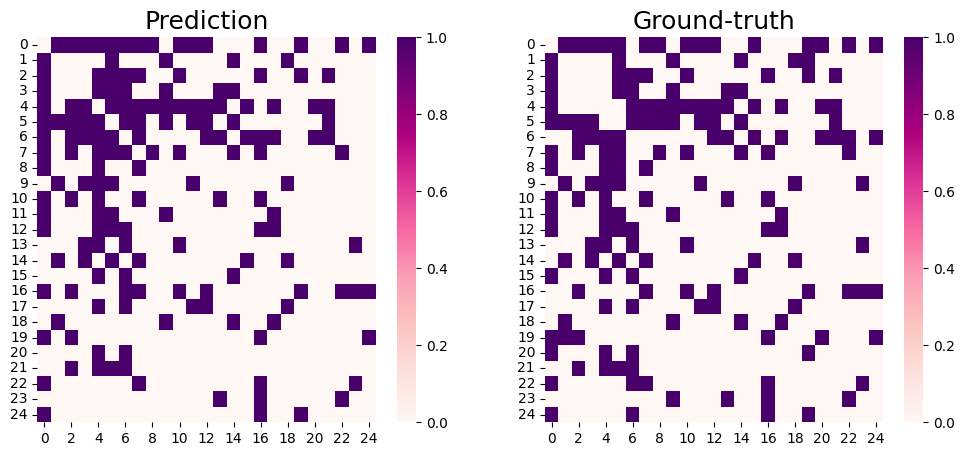

In [117]:
temp3 = [ [0]*graph_size for _ in range(graph_size) ]
temp4 = main_data['W'][index].toarray()

for i in range(graph_size):
    for j in range(i+1, graph_size):
        if adjacency_matrix[i][j]>=threshold:
            temp3[i][j]=1
            temp3[j][i]=1
        if temp4[i][j]>0:
            temp4[i][j]=1
            temp4[j][i]=1

fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
sns.heatmap(temp3, cmap = 'RdPu',  ax=axs[0])
axs[0].set_title('Prediction', fontsize=18)
sns.heatmap(temp4, cmap = 'RdPu', ax=axs[1])
axs[1].set_title('Ground-truth', fontsize=18)
plt.show()

## Preformance Evaluation

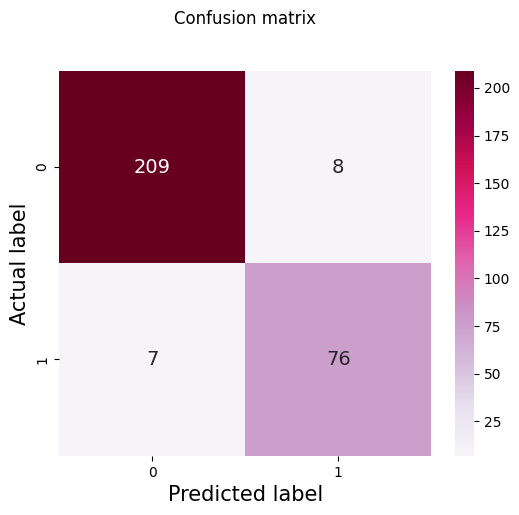

In [118]:
f, ax = plt.subplots(figsize=(6,5))
cm = confusion_matrix(squareform(temp3), squareform(temp4))
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="PuRd" ,fmt='g', annot_kws={"size": 14})
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label', fontsize=15)
plt.xlabel('Predicted label', fontsize=15)
plt.show()

In [119]:
TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
FP = cm[0][1]

FPP = FP/(FP+TN)
FNP = FN/(TP+FN)
Precision = TP/(TP+FP)
Recall = TP/(TP+FN)
Specificity = TN/(TN+FP)
F1 = (2*Precision*Recall)/(Precision+Recall)
ACC = (TP+TN)/(TP+FP+FN+TN)

print('False Positive Proportion: ', np.round(FPP, 4))
print('False Negative Proportion: ', np.round(FNP, 4))
print('Precision : \t', np.round(Precision, 4))
print('Recall: \t', np.round(Recall, 4))
print('Specificity : \t', np.round(Specificity, 4))
print('F1 Score: \t', np.round(F1, 4))
print('Accuracy: \t', np.round(ACC, 4))

False Positive Proportion:  0.0369
False Negative Proportion:  0.0843
Precision : 	 0.9048
Recall: 	 0.9157
Specificity : 	 0.9631
F1 Score: 	 0.9102
Accuracy: 	 0.95


## How to choose k?

In [120]:
accuracy = []
ks = np.arange(1,11,1)

for k in ks:
    adjacency_matrix = [ [0]*graph_size for _ in range(graph_size) ]
    count_matrix = [ [0]*graph_size for _ in range(graph_size) ]
    combinations = k_combinations(graph_size,base_size,k)
    z_squareform = squareform(main_data['z'][index])

    for comb in combinations:
        mini_combinations = list(itertools.combinations(comb, 2))
        new_z = []
        for minicomb in mini_combinations:
            new_z.append(z_squareform[minicomb[0]][minicomb[1]])
            count_matrix[minicomb[0]][minicomb[1]] += 1
            count_matrix[minicomb[1]][minicomb[0]] += 1

        new_z_tt = torch.tensor([new_z]).float().to(device)
        w_list = net.validation(new_z_tt , threshold=1e-04)
        w_pred = torch.clamp(w_list[:, - 1, :], min=0)[0].detach().cpu().numpy()

        for i, minicomb in enumerate(mini_combinations):
            adjacency_matrix[minicomb[0]][minicomb[1]] += w_pred[i]
            adjacency_matrix[minicomb[1]][minicomb[0]] += w_pred[i]
    for i in range(graph_size):
        for j in range(i+1, graph_size):
            if count_matrix[i][j] is not 0:
                adjacency_matrix[i][j] /= count_matrix[i][j]
                adjacency_matrix[j][i] /= count_matrix[j][i]

    temp1 = [ [0]*graph_size for _ in range(graph_size) ]
    temp2 = main_data['W'][index].toarray()

    for i in range(len(temp1)):
        for j in range(len(temp1)):
            if adjacency_matrix[i][j]>=threshold:
                temp1[i][j]=1
            else:
                temp1[i][j]=0
            if temp2[i][j]>0:
                temp2[i][j]=1

    cm = confusion_matrix(squareform(temp1), squareform(temp2))
    TN = cm[0][0]
    FN = cm[1][0]
    TP = cm[1][1]
    FP = cm[0][1]
    ACC = (TP+TN)/(TP+FP+FN+TN)
    accuracy.append(ACC)

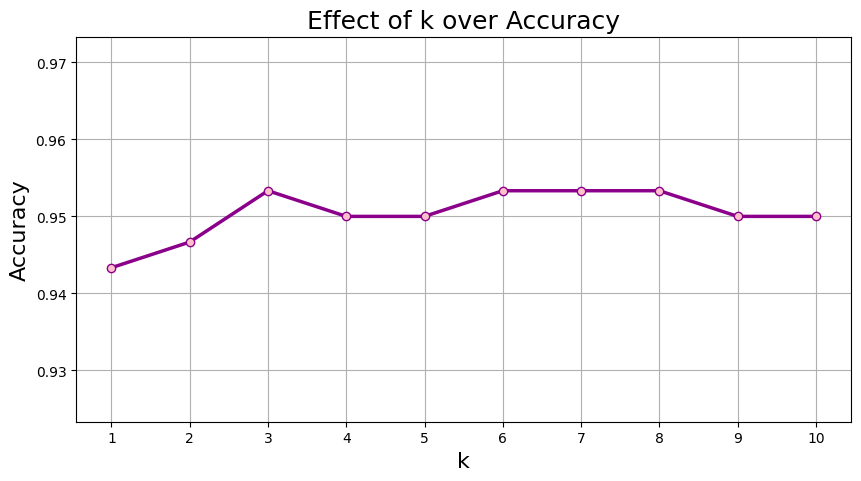

In [121]:
plt.figure(figsize=(10,5))
plt.plot(ks, accuracy, color='darkmagenta', marker='o', mfc='pink', linewidth=2.5 )

plt.ylabel('Accuracy', fontsize=16)
plt.xlabel('k', fontsize=16)
plt.title("Effect of k over Accuracy", fontsize=18)
plt.ylim([min(accuracy)-0.02, max(accuracy)+0.02])
plt.xticks(ks)
plt.grid()
plt.savefig('Figure4.png', bbox_inches='tight')

plt.show()

## How to choose the threshold?

In [32]:
ACC = []
SPEC = []
RCLL = []
FONE = []
PREC = []
k = 5
thresholds = np.arange(0.13, 0.18, 0.001)

for threshold in thresholds:
    adjacency_matrix = [ [0]*graph_size for _ in range(graph_size) ]
    count_matrix = [ [0]*graph_size for _ in range(graph_size) ]
    combinations = k_combinations(graph_size,base_size,k)
    z_squareform = squareform(main_data['z'][index])

    for comb in combinations:
        mini_combinations = list(itertools.combinations(comb, 2))
        new_z = []
        for minicomb in mini_combinations:
            new_z.append(z_squareform[minicomb[0]][minicomb[1]])
            count_matrix[minicomb[0]][minicomb[1]] += 1
            count_matrix[minicomb[1]][minicomb[0]] += 1

        new_z_tt = torch.tensor([new_z]).float().to(device)
        w_list = net.validation(new_z_tt , threshold=1e-04)
        w_pred = torch.clamp(w_list[:, - 1, :], min=0)[0].detach().cpu().numpy()

        for i, minicomb in enumerate(mini_combinations):
            adjacency_matrix[minicomb[0]][minicomb[1]] += w_pred[i]
            adjacency_matrix[minicomb[1]][minicomb[0]] += w_pred[i]
    for i in range(graph_size):
        for j in range(i+1, graph_size):
            if count_matrix[i][j] is not 0:
                adjacency_matrix[i][j] /= count_matrix[i][j]
                adjacency_matrix[j][i] /= count_matrix[j][i]

    temp1 = [ [0]*graph_size for _ in range(graph_size) ]
    temp2 = main_data['W'][index].toarray()

    for i in range(len(temp1)):
        for j in range(len(temp1)):
            if adjacency_matrix[i][j]>=threshold:
                temp1[i][j]=1
            else:
                temp1[i][j]=0
            if temp2[i][j]>0:
                temp2[i][j]=1

    cm = confusion_matrix(squareform(temp1), squareform(temp2))
    TN = cm[0][0]
    FN = cm[1][0]
    TP = cm[1][1]
    FP = cm[0][1]
    Accuracy = (TP+TN)/(TP+FP+FN+TN)
    Recall = TP/(TP+FN)
    Specificity = TN/(TN+FP)
    Precision = TP/(TP+FP)
    F1 = (2*Precision*Recall)/(Precision+Recall)
    ACC.append(Accuracy)
    SPEC.append(Specificity)
    RCLL.append(Recall)
    FONE.append(F1)
    PREC.append(Precision)

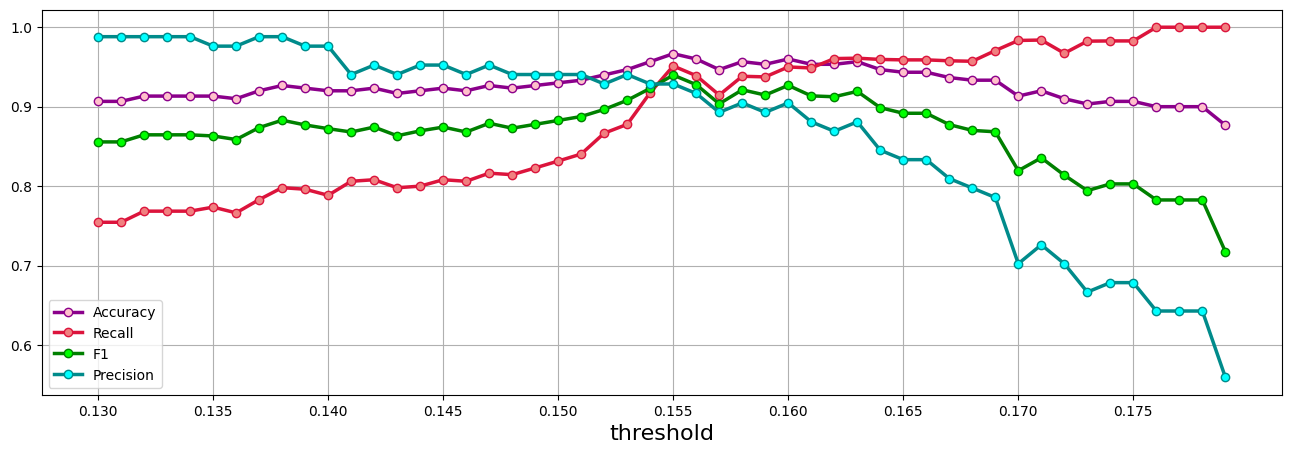

In [37]:
plt.figure(figsize=(16,5))
plt.plot(thresholds, ACC, label='Accuracy' ,color='darkmagenta', marker='o', mfc='pink', linewidth=2.5 )
# plt.plot(thresholds, SPEC, label='Specificity' ,color='darkcyan', marker='o', mfc='cyan', linewidth=2.5 )
plt.plot(thresholds, RCLL, label='Recall' ,color='crimson', marker='o', mfc='lightcoral', linewidth=2.5 )
plt.plot(thresholds, FONE, label='F1' ,color='green', marker='o', mfc='lime', linewidth=2.5 )
plt.plot(thresholds, PREC, label='Precision' ,color='darkcyan', marker='o', mfc='cyan', linewidth=2.5 )

plt.xlabel('threshold', fontsize=16)
plt.title("Effect of threshold", fontsize=18)
plt.xticks(np.arange(min(thresholds), max(thresholds), 0.005))
plt.grid()
plt.legend()
plt.show()

# Test 2 - SBM 15

In [12]:
graph_size = 15

In [13]:
weight = 'gaussian'
main_data = generate_SBM15_parallel(num_samples=10,
                            num_signals=4000,
                            num_nodes=graph_size,
                            weighted=weight,
                            weight_scale=True)

index = 5

***one data sample***

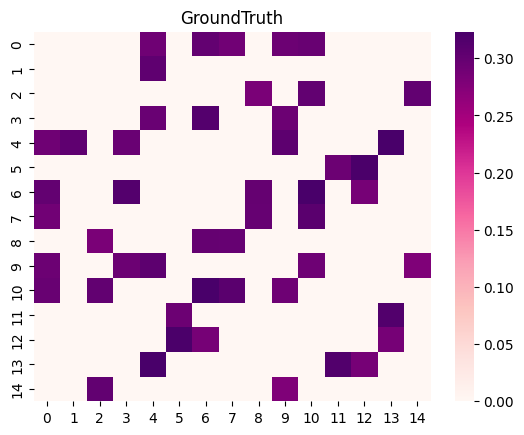

In [14]:
plt.figure()
sns.heatmap(main_data['W'][index].toarray(), cmap = 'RdPu')
plt.title('GroundTruth')
plt.show()

In [15]:
print('Number of Combinations {} out of {}:'.format(base_size ,graph_size))
print(nCr(graph_size,base_size))

Number of Combinations 10 out of 15:
3003


## K-combination Method

In [16]:
k = 5
print('Number of {}-Combinations {} out of {}:'.format(k, base_size, graph_size))
print(graph_size*(graph_size-1)//2*k)

Number of 5-Combinations 10 out of 15:
525


In [17]:
threshold = 0.2
adjacency_matrix = [ [0]*graph_size for _ in range(graph_size) ]
count_matrix = [ [0]*graph_size for _ in range(graph_size) ]
combinations = k_combinations(graph_size, base_size, k)
z_squareform = squareform(main_data['z'][index])

for comb in combinations:
    mini_combinations = list(itertools.combinations(comb, 2))
    new_z = []
    for minicomb in mini_combinations:
        new_z.append(z_squareform[minicomb[0]][minicomb[1]])
        count_matrix[minicomb[0]][minicomb[1]] += 1
        count_matrix[minicomb[1]][minicomb[0]] += 1

    new_z_tt = torch.tensor([new_z]).float().to(device)
    w_list = net.validation(new_z_tt , threshold=1e-04)
    w_pred = torch.clamp(w_list[:, - 1, :], min=0)[0].detach().cpu().numpy()

    for i, minicomb in enumerate(mini_combinations):
        adjacency_matrix[minicomb[0]][minicomb[1]] += w_pred[i]
        adjacency_matrix[minicomb[1]][minicomb[0]] += w_pred[i]

temp1 = [ [0]*graph_size for _ in range(graph_size) ]
temp2 = main_data['W'][index].toarray()


for i in range(graph_size):
    for j in range(i+1, graph_size):
        if count_matrix[i][j] is not 0:
            adjacency_matrix[i][j] /= count_matrix[i][j]
            adjacency_matrix[j][i] /= count_matrix[j][i]
        if adjacency_matrix[i][j]<threshold:
            temp1[i][j]=0
            temp1[j][i]=0
        else:
            temp1[i][j]=adjacency_matrix[i][j]
            temp1[j][i]=adjacency_matrix[j][i]

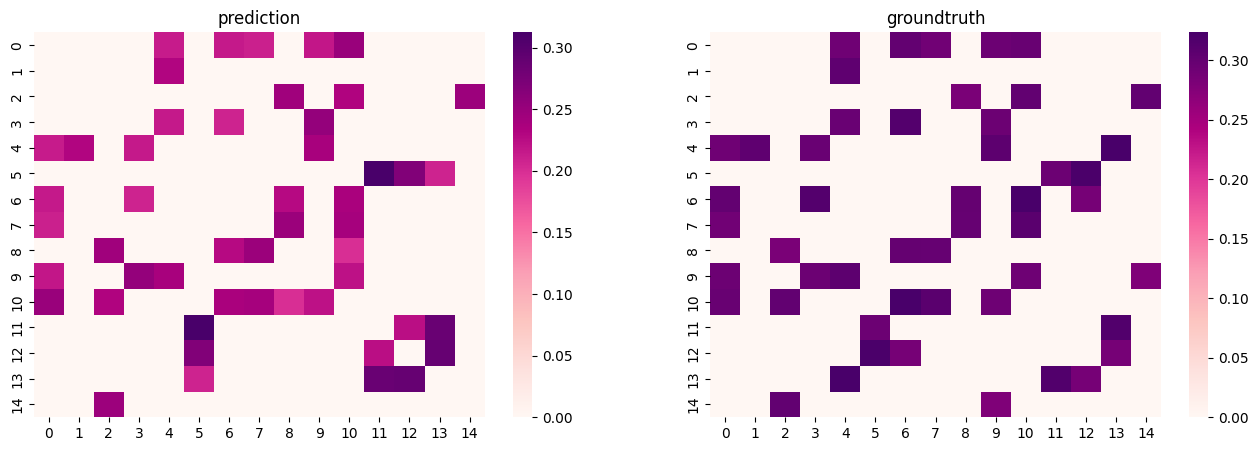

In [18]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 5))
sns.heatmap(temp1, cmap = 'RdPu',  ax=axs[0])
axs[0].set_title('prediction')
sns.heatmap(temp2, cmap = 'RdPu', ax=axs[1])
axs[1].set_title('groundtruth')
plt.show()

## Binarization

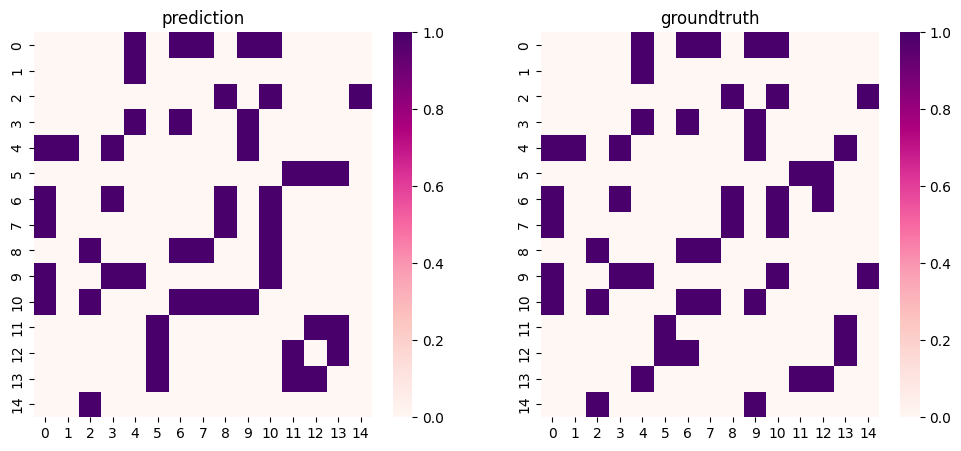

In [19]:
temp3 = [ [0]*graph_size for _ in range(graph_size) ]
temp4 = main_data['W'][index].toarray()

for i in range(graph_size):
    for j in range(i+1, graph_size):
        if adjacency_matrix[i][j]>=threshold:
            temp3[i][j]=1
            temp3[j][i]=1
        if temp4[i][j]>0:
            temp4[i][j]=1
            temp4[j][i]=1

fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
sns.heatmap(temp3, cmap = 'RdPu',  ax=axs[0])
axs[0].set_title('prediction')
sns.heatmap(temp4, cmap = 'RdPu', ax=axs[1])
axs[1].set_title('groundtruth')
plt.show()

## Preformance Evaluation

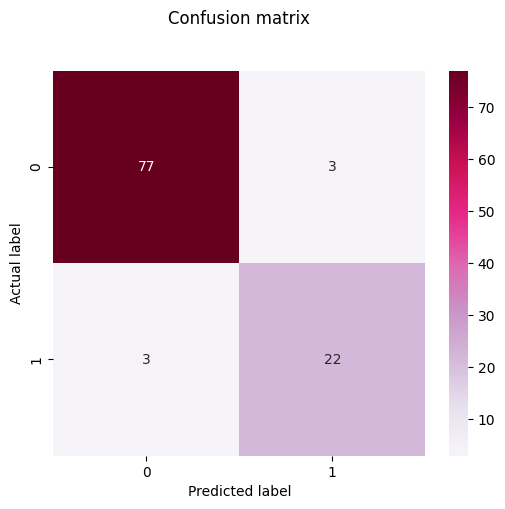

In [20]:
f, ax = plt.subplots(figsize=(6,5))
cm = confusion_matrix(squareform(temp3), squareform(temp4))
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="PuRd" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [21]:
TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
FP = cm[0][1]

FPP = FP/(FP+TN)
FNP = FN/(TP+FN)
Precision = TP/(TP+FP)
Recall = TP/(TP+FN)
Specificity = TN/(TN+FP)
F1 = (2*Precision*Recall)/(Precision+Recall)
ACC = (TP+TN)/(TP+FP+FN+TN)

print('False Positive Proportion: ', np.round(FPP, 4))
print('False Negative Proportion: ', np.round(FNP, 4))
print('Precision : \t', np.round(Precision, 4))
print('Recall: \t', np.round(Recall, 4))
print('Specificity: \t', np.round(Specificity, 4))
print('F1 Score: \t', np.round(F1, 4))
print('Accuracy: \t', np.round(ACC, 4))

False Positive Proportion:  0.0375
False Negative Proportion:  0.12
Precision : 	 0.88
Recall: 	 0.88
Specificity: 	 0.9625
F1 Score: 	 0.88
Accuracy: 	 0.9429


# Test 3 - ER 30

In [167]:
graph_size = 30

In [169]:
weight = 'gaussian'
main_data = generate_ER_parallel(num_samples=10,
                            num_signals=4000,
                            num_nodes=graph_size,
                            graph_hyper={'p':0.4},
                            weighted=weight,
                            weight_scale=True)

index = 5

***one data sample***

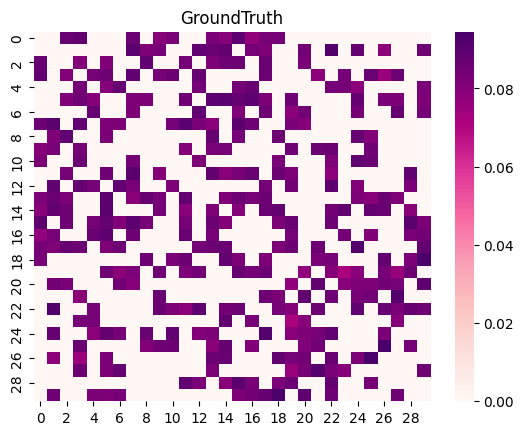

In [170]:
plt.figure()
sns.heatmap(main_data['W'][index].toarray(), cmap = 'RdPu')
plt.title('GroundTruth')
plt.show()

In [171]:
print('Number of Combinations {} out of {}:'.format(base_size ,graph_size))
print(nCr(graph_size,base_size))

Number of Combinations 10 out of 30:
30045015


## K-combination Method

In [172]:
k = 5
print('Number of {}-Combinations {} out of {}:'.format(k, base_size, graph_size))
print(graph_size*(graph_size-1)//2*k)

Number of 5-Combinations 10 out of 30:
2175


In [173]:
threshold = 0.1268
adjacency_matrix = [ [0]*graph_size for _ in range(graph_size) ]
count_matrix = [ [0]*graph_size for _ in range(graph_size) ]
combinations = k_combinations(graph_size,base_size,k)
z_squareform = squareform(main_data['z'][index])

for comb in combinations:
    mini_combinations = list(itertools.combinations(comb, 2))
    new_z = []
    for minicomb in mini_combinations:
        new_z.append(z_squareform[minicomb[0]][minicomb[1]])
        count_matrix[minicomb[0]][minicomb[1]] += 1
        count_matrix[minicomb[1]][minicomb[0]] += 1

    new_z_tt = torch.tensor([new_z]).float().to(device)
    w_list = net.validation(new_z_tt , threshold=1e-04)
    w_pred = torch.clamp(w_list[:, - 1, :], min=0)[0].detach().cpu().numpy()

    for i, minicomb in enumerate(mini_combinations):
        adjacency_matrix[minicomb[0]][minicomb[1]] += w_pred[i]
        adjacency_matrix[minicomb[1]][minicomb[0]] += w_pred[i]

temp1 = [ [0]*graph_size for _ in range(graph_size) ]
temp2 = main_data['W'][index].toarray()
threshold = 0.1268

for i in range(graph_size):
    for j in range(i+1, graph_size):
        if count_matrix[i][j] is not 0:
            adjacency_matrix[i][j] /= count_matrix[i][j]
            adjacency_matrix[j][i] /= count_matrix[j][i]
        if adjacency_matrix[i][j]<threshold:
            temp1[i][j]=0
            temp1[j][i]=0
        else:
            temp1[i][j]=adjacency_matrix[i][j]
            temp1[j][i]=adjacency_matrix[j][i]

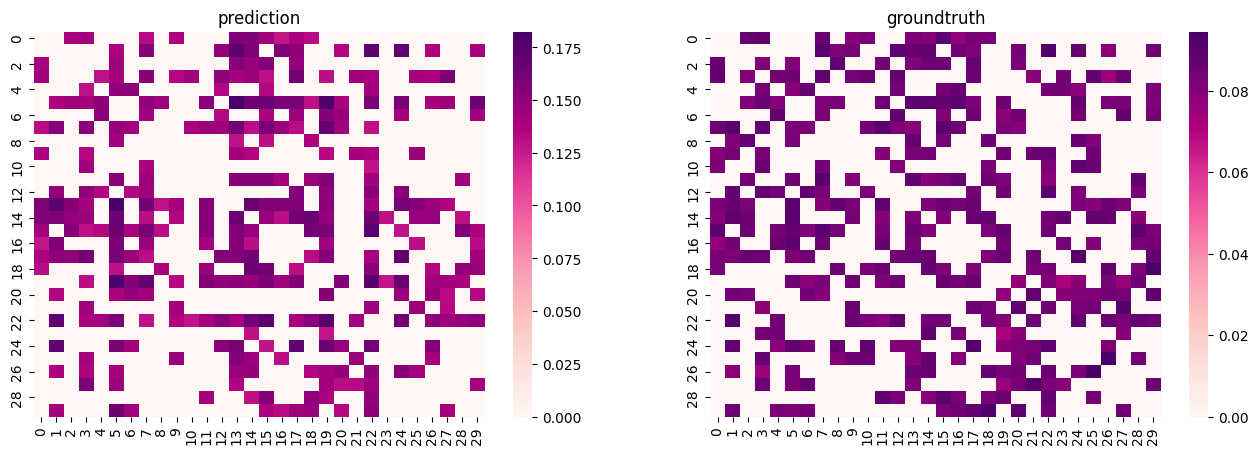

In [174]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 5))
sns.heatmap(temp1, cmap = 'RdPu',  ax=axs[0])
axs[0].set_title('prediction')
sns.heatmap(temp2, cmap = 'RdPu', ax=axs[1])
axs[1].set_title('groundtruth')
plt.show()

## Binarization

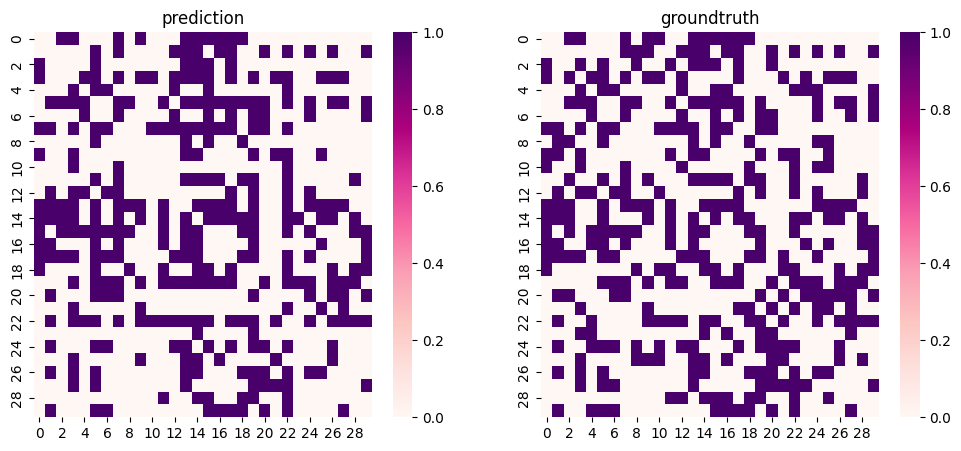

In [175]:
temp3 = [ [0]*graph_size for _ in range(graph_size) ]
temp4 = main_data['W'][index].toarray()

for i in range(graph_size):
    for j in range(i+1, graph_size):
        if adjacency_matrix[i][j]>=threshold:
            temp3[i][j]=1
            temp3[j][i]=1
        if temp4[i][j]>0:
            temp4[i][j]=1
            temp4[j][i]=1

fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
sns.heatmap(temp3, cmap = 'RdPu',  ax=axs[0])
axs[0].set_title('prediction')
sns.heatmap(temp4, cmap = 'RdPu', ax=axs[1])
axs[1].set_title('groundtruth')
plt.show()

## Preformance Evaluation

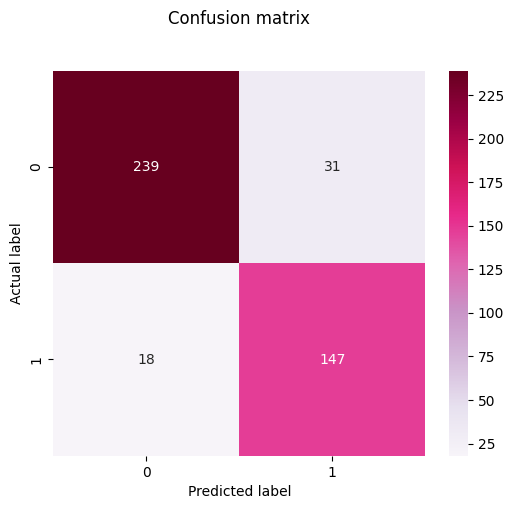

In [176]:
f, ax = plt.subplots(figsize=(6,5))
cm = confusion_matrix(squareform(temp3), squareform(temp4))
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="PuRd" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [177]:
TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
FP = cm[0][1]

FPP = FP/(FP+TN)
FNP = FN/(TP+FN)
Precision = TP/(TP+FP)
Recall = TP/(TP+FN)
Specificity = TN/(TN+FP)
F1 = (2*Precision*Recall)/(Precision+Recall)
ACC = (TP+TN)/(TP+FP+FN+TN)

print('False Positive Proportion: ', np.round(FPP, 4))
print('False Negative Proportion: ', np.round(FNP, 4))
print('Precision : \t', np.round(Precision, 4))
print('Recall: \t', np.round(Recall, 4))
print('Specificity : \t', np.round(Specificity, 4))
print('F1 Score: \t', np.round(F1, 4))
print('Accuracy: \t', np.round(ACC, 4))

False Positive Proportion:  0.1148
False Negative Proportion:  0.1091
Precision : 	 0.8258
Recall: 	 0.8909
Specificity : 	 0.8852
F1 Score: 	 0.8571
Accuracy: 	 0.8874


# Test 4 - WS 50

In [178]:
graph_size = 50

In [179]:
weight = 'gaussian'
main_data = generate_WS_parallel(num_samples=10,
                            num_signals=4000,
                            num_nodes=graph_size,
                            graph_hyper={'k':20, 'p':0.15},
                            weighted=weight,
                            weight_scale=True)

index = 8

***one data sample***

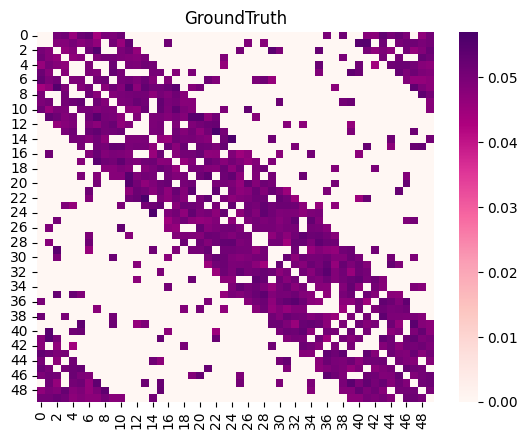

In [180]:
plt.figure()
sns.heatmap(main_data['W'][index].toarray(), cmap = 'RdPu')
plt.title('GroundTruth')
plt.show()

In [181]:
print('Number of Combinations {} out of {}:'.format(base_size ,graph_size))
print(nCr(graph_size,base_size))

Number of Combinations 10 out of 50:
10272278170


## K-combination Method

In [182]:
k = 5
print('Number of {}-Combinations {} out of {}:'.format(k, base_size, graph_size))
print(graph_size*(graph_size-1)//2*k)

Number of 5-Combinations 10 out of 50:
6125


In [183]:
threshold = 0.1177
adjacency_matrix = [ [0]*graph_size for _ in range(graph_size) ]
count_matrix = [ [0]*graph_size for _ in range(graph_size) ]
combinations = k_combinations(graph_size,base_size,k)
z_squareform = squareform(main_data['z'][index])

for comb in combinations:
    mini_combinations = list(itertools.combinations(comb, 2))
    new_z = []
    for minicomb in mini_combinations:
        new_z.append(z_squareform[minicomb[0]][minicomb[1]])
        count_matrix[minicomb[0]][minicomb[1]] += 1
        count_matrix[minicomb[1]][minicomb[0]] += 1

    new_z_tt = torch.tensor([new_z]).float().to(device)
    w_list = net.validation(new_z_tt , threshold=1e-04)
    w_pred = torch.clamp(w_list[:, - 1, :], min=0)[0].detach().cpu().numpy()

    for i, minicomb in enumerate(mini_combinations):
        adjacency_matrix[minicomb[0]][minicomb[1]] += w_pred[i]
        adjacency_matrix[minicomb[1]][minicomb[0]] += w_pred[i]

temp1 = [ [0]*graph_size for _ in range(graph_size) ]
temp2 = main_data['W'][index].toarray()
threshold = 0.1177

for i in range(graph_size):
    for j in range(i+1, graph_size):
        if count_matrix[i][j] is not 0:
            adjacency_matrix[i][j] /= count_matrix[i][j]
            adjacency_matrix[j][i] /= count_matrix[j][i]
        if adjacency_matrix[i][j]<threshold:
            temp1[i][j]=0
            temp1[j][i]=0
        else:
            temp1[i][j]=adjacency_matrix[i][j]
            temp1[j][i]=adjacency_matrix[j][i]

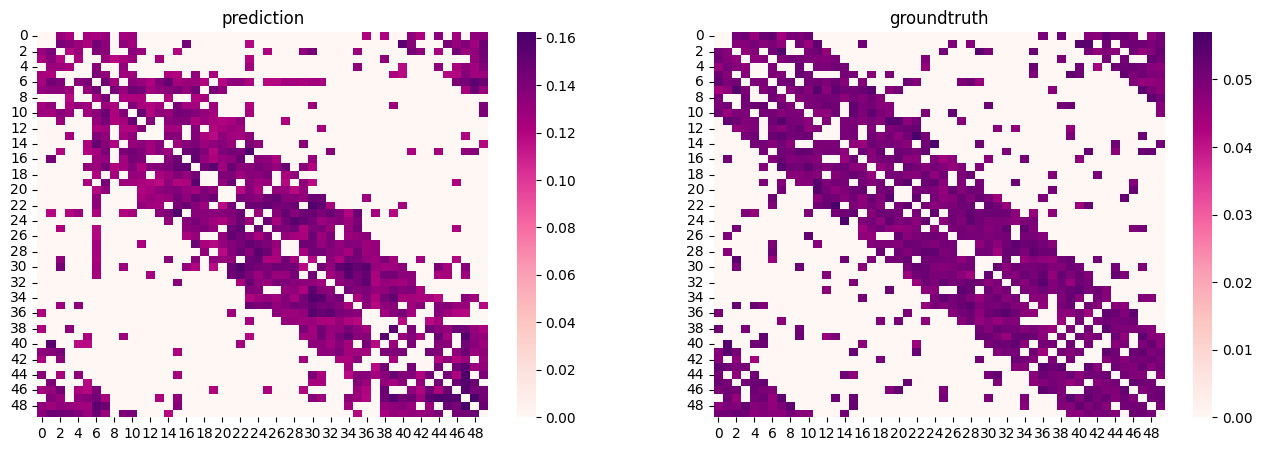

In [184]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 5))
sns.heatmap(temp1, cmap = 'RdPu',  ax=axs[0])
axs[0].set_title('prediction')
sns.heatmap(temp2, cmap = 'RdPu', ax=axs[1])
axs[1].set_title('groundtruth')
plt.show()

## Binarization

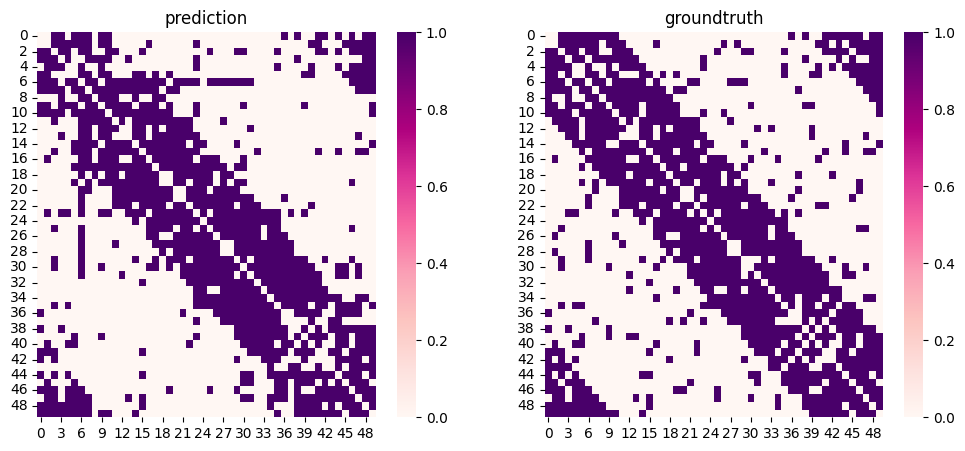

In [185]:
temp3 = [ [0]*graph_size for _ in range(graph_size) ]
temp4 = main_data['W'][index].toarray()

for i in range(graph_size):
    for j in range(i+1, graph_size):
        if adjacency_matrix[i][j]>=threshold:
            temp3[i][j]=1
            temp3[j][i]=1
        if temp4[i][j]>0:
            temp4[i][j]=1
            temp4[j][i]=1

fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
sns.heatmap(temp3, cmap = 'RdPu',  ax=axs[0])
axs[0].set_title('prediction')
sns.heatmap(temp4, cmap = 'RdPu', ax=axs[1])
axs[1].set_title('groundtruth')
plt.show()

## Preformance Evaluation

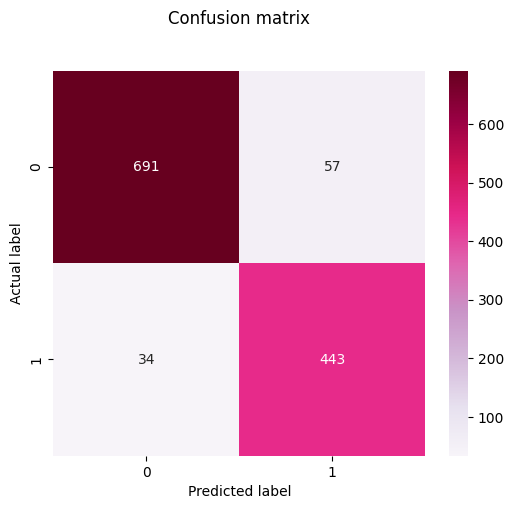

In [186]:
f, ax = plt.subplots(figsize=(6,5))
cm = confusion_matrix(squareform(temp3), squareform(temp4))
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="PuRd" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [187]:
TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
FP = cm[0][1]

FPP = FP/(FP+TN)
FNP = FN/(TP+FN)
Precision = TP/(TP+FP)
Recall = TP/(TP+FN)
Specificity = TN/(TN+FP)
F1 = (2*Precision*Recall)/(Precision+Recall)
ACC = (TP+TN)/(TP+FP+FN+TN)

print('False Positive Proportion: ', np.round(FPP, 4))
print('False Negative Proportion: ', np.round(FNP, 4))
print('Precision : \t', np.round(Precision, 4))
print('Recall: \t', np.round(Recall, 4))
print('Specificity : \t', np.round(Specificity, 4))
print('F1 Score: \t', np.round(F1, 4))
print('Accuracy: \t', np.round(ACC, 4))

False Positive Proportion:  0.0762
False Negative Proportion:  0.0713
Precision : 	 0.886
Recall: 	 0.9287
Specificity : 	 0.9238
F1 Score: 	 0.9069
Accuracy: 	 0.9257


# Test 5 - SBM 75

In [24]:
graph_size = 75

In [25]:
weight = 'gaussian'
main_data = generate_SBM75_parallel(num_samples=10,
                            num_signals=4000,
                            num_nodes=graph_size,
                            weighted=weight,
                            weight_scale=True)

index = 5

***one data sample***

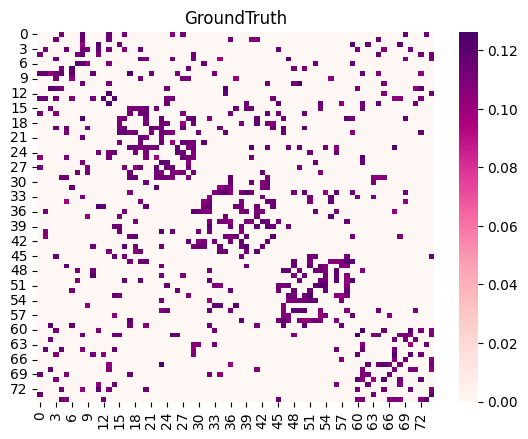

In [26]:
plt.figure()
sns.heatmap(main_data['W'][index].toarray(), cmap = 'RdPu')
plt.title('GroundTruth')
plt.show()

In [27]:
print('Number of Combinations {} out of {}:'.format(base_size ,graph_size))
print(nCr(graph_size,base_size))

Number of Combinations 10 out of 75:
828931106355


## K-combination Method

In [28]:
k = 5
print('Number of {}-Combinations {} out of {}:'.format(k, base_size, graph_size))
print(graph_size*(graph_size-1)//2*k)

Number of 5-Combinations 10 out of 75:
13875


In [29]:
threshold = 0.1675
adjacency_matrix = [ [0]*graph_size for _ in range(graph_size) ]
count_matrix = [ [0]*graph_size for _ in range(graph_size) ]
combinations = k_combinations(graph_size,base_size,k)
z_squareform = squareform(main_data['z'][index])

for comb in combinations:
    mini_combinations = list(itertools.combinations(comb, 2))
    new_z = []
    for minicomb in mini_combinations:
        new_z.append(z_squareform[minicomb[0]][minicomb[1]])
        count_matrix[minicomb[0]][minicomb[1]] += 1
        count_matrix[minicomb[1]][minicomb[0]] += 1

    new_z_tt = torch.tensor([new_z]).float().to(device)
    w_list = net.validation(new_z_tt , threshold=1e-04)
    w_pred = torch.clamp(w_list[:, - 1, :], min=0)[0].detach().cpu().numpy()

    for i, minicomb in enumerate(mini_combinations):
        adjacency_matrix[minicomb[0]][minicomb[1]] += w_pred[i]
        adjacency_matrix[minicomb[1]][minicomb[0]] += w_pred[i]

temp1 = [ [0]*graph_size for _ in range(graph_size) ]
temp2 = main_data['W'][index].toarray()

for i in range(graph_size):
    for j in range(i+1, graph_size):
        if count_matrix[i][j] is not 0:
            adjacency_matrix[i][j] /= count_matrix[i][j]
            adjacency_matrix[j][i] /= count_matrix[j][i]
        if adjacency_matrix[i][j]<threshold:
            temp1[i][j]=0
            temp1[j][i]=0
        else:
            temp1[i][j]=adjacency_matrix[i][j]
            temp1[j][i]=adjacency_matrix[j][i]

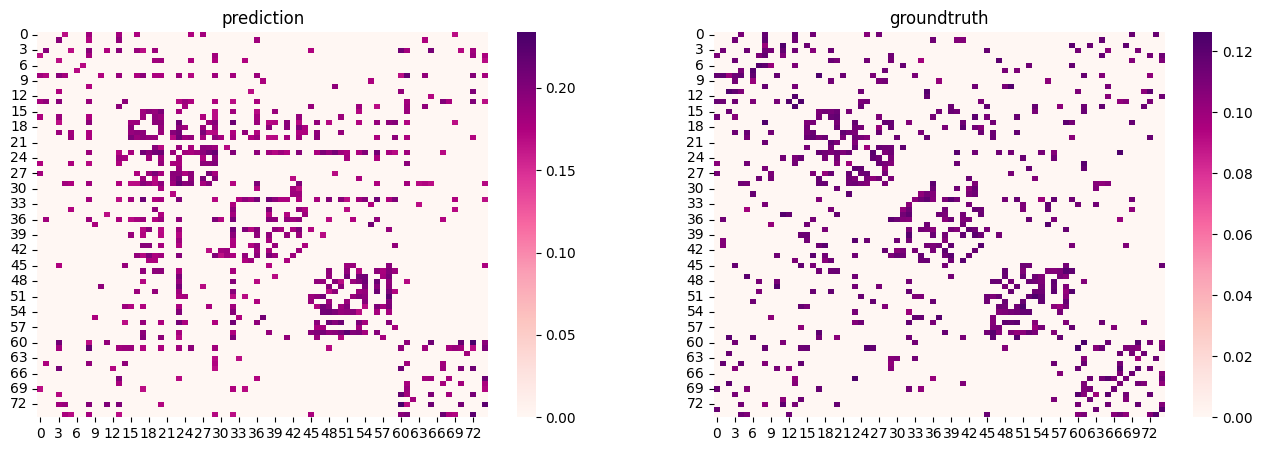

In [30]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 5))
sns.heatmap(temp1, cmap = 'RdPu',  ax=axs[0])
axs[0].set_title('prediction')
sns.heatmap(temp2, cmap = 'RdPu', ax=axs[1])
axs[1].set_title('groundtruth')
plt.show()

## Binarization

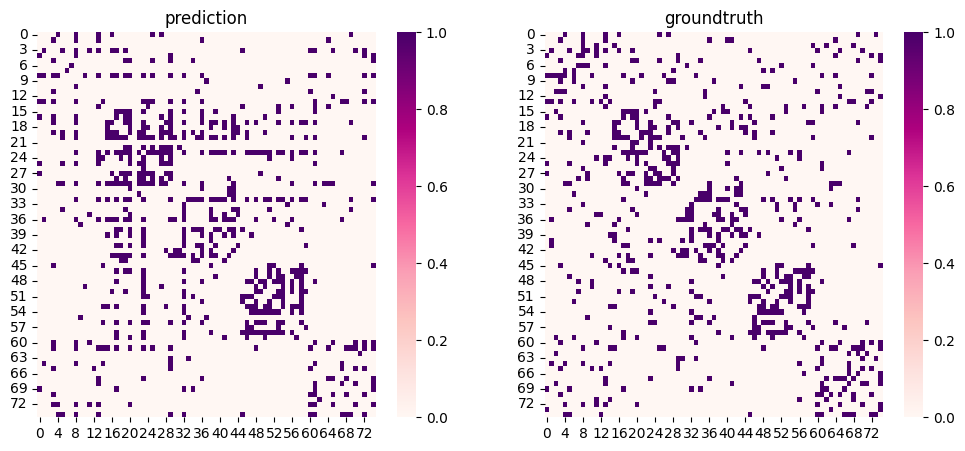

In [31]:
temp3 = [ [0]*graph_size for _ in range(graph_size) ]
temp4 = main_data['W'][index].toarray()

for i in range(graph_size):
    for j in range(i+1, graph_size):
        if adjacency_matrix[i][j]>=threshold:
            temp3[i][j]=1
            temp3[j][i]=1
        if temp4[i][j]>0:
            temp4[i][j]=1
            temp4[j][i]=1

fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
sns.heatmap(temp3, cmap = 'RdPu',  ax=axs[0])
axs[0].set_title('prediction')
sns.heatmap(temp4, cmap = 'RdPu', ax=axs[1])
axs[1].set_title('groundtruth')
plt.show()

## Preformance Evaluation

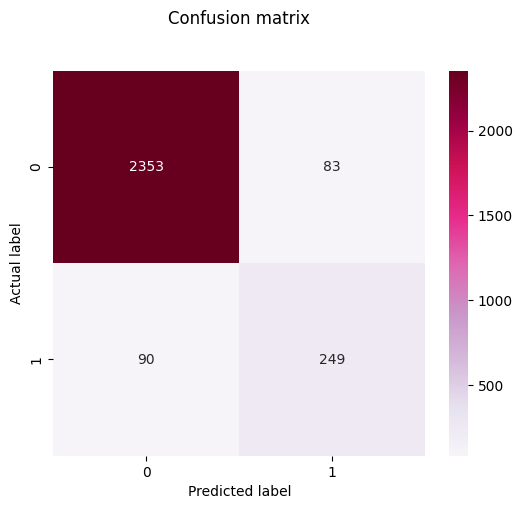

In [32]:
f, ax = plt.subplots(figsize=(6,5))
cm = confusion_matrix(squareform(temp3), squareform(temp4))
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="PuRd" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [33]:
TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
FP = cm[0][1]

FPP = FP/(FP+TN)
FNP = FN/(TP+FN)
Precision = TP/(TP+FP)
Recall = TP/(TP+FN)
Specificity = TN/(TN+FP)
F1 = (2*Precision*Recall)/(Precision+Recall)
ACC = (TP+TN)/(TP+FP+FN+TN)

print('False Positive Proportion: ', np.round(FPP, 4))
print('False Negative Proportion: ', np.round(FNP, 4))
print('Precision : \t', np.round(Precision, 4))
print('Recall: \t', np.round(Recall, 4))
print('Specificity : \t', np.round(Specificity, 4))
print('F1 Score: \t', np.round(F1, 4))
print('Accuracy: \t', np.round(ACC, 4))

False Positive Proportion:  0.0341
False Negative Proportion:  0.2655
Precision : 	 0.75
Recall: 	 0.7345
Specificity : 	 0.9659
F1 Score: 	 0.7422
Accuracy: 	 0.9377


# Test 6 - WS 125

In [190]:
graph_size = 125

In [191]:
weight = 'uniform'
main_data = generate_WS_parallel(num_samples=10,
                            num_signals=4000,
                            num_nodes=graph_size,
                            graph_hyper={'k':30, 'p':0.15},
                            weighted=weight,
                            weight_scale=True)

index = 8

***one data sample***

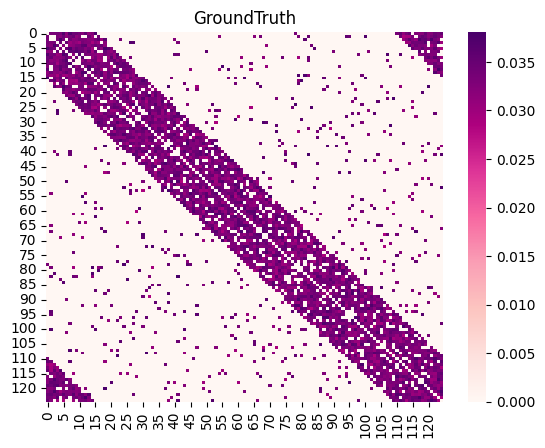

In [192]:
plt.figure()
sns.heatmap(main_data['W'][index].toarray(), cmap = 'RdPu')
plt.title('GroundTruth')
plt.show()

In [193]:
print('Number of Combinations {} out of {}:'.format(base_size ,graph_size))
print(nCr(graph_size,base_size))

Number of Combinations 10 out of 125:
177367091094050


## K-combination Method

In [194]:
k = 5
print('Number of {}-Combinations {} out of {}:'.format(k, base_size, graph_size))
print(graph_size*(graph_size-1)//2*k)

Number of 5-Combinations 10 out of 125:
38750


In [195]:
threshold = 0.12625
adjacency_matrix = [ [0]*graph_size for _ in range(graph_size) ]
count_matrix = [ [0]*graph_size for _ in range(graph_size) ]
combinations = k_combinations(graph_size,base_size,k)
z_squareform = squareform(main_data['z'][index])

for comb in combinations:
    mini_combinations = list(itertools.combinations(comb, 2))
    new_z = []
    for minicomb in mini_combinations:
        new_z.append(z_squareform[minicomb[0]][minicomb[1]])
        count_matrix[minicomb[0]][minicomb[1]] += 1
        count_matrix[minicomb[1]][minicomb[0]] += 1

    new_z_tt = torch.tensor([new_z]).float().to(device)
    w_list = net.validation(new_z_tt , threshold=1e-04)
    w_pred = torch.clamp(w_list[:, - 1, :], min=0)[0].detach().cpu().numpy()

    for i, minicomb in enumerate(mini_combinations):
        adjacency_matrix[minicomb[0]][minicomb[1]] += w_pred[i]
        adjacency_matrix[minicomb[1]][minicomb[0]] += w_pred[i]

temp1 = [ [0]*graph_size for _ in range(graph_size) ]
temp2 = main_data['W'][index].toarray()

for i in range(graph_size):
    for j in range(i+1, graph_size):
        if count_matrix[i][j] is not 0:
            adjacency_matrix[i][j] /= count_matrix[i][j]
            adjacency_matrix[j][i] /= count_matrix[j][i]
        if adjacency_matrix[i][j]<threshold:
            temp1[i][j]=0
            temp1[j][i]=0
        else:
            temp1[i][j]=adjacency_matrix[i][j]
            temp1[j][i]=adjacency_matrix[j][i]

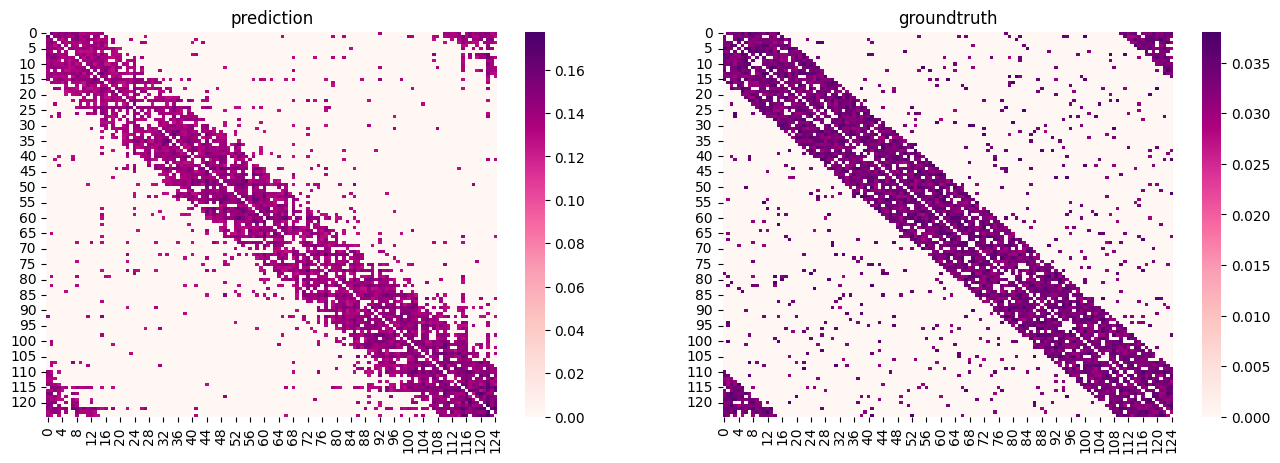

In [196]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 5))
sns.heatmap(temp1, cmap = 'RdPu',  ax=axs[0])
axs[0].set_title('prediction')
sns.heatmap(temp2, cmap = 'RdPu', ax=axs[1])
axs[1].set_title('groundtruth')
plt.show()

## Binarization

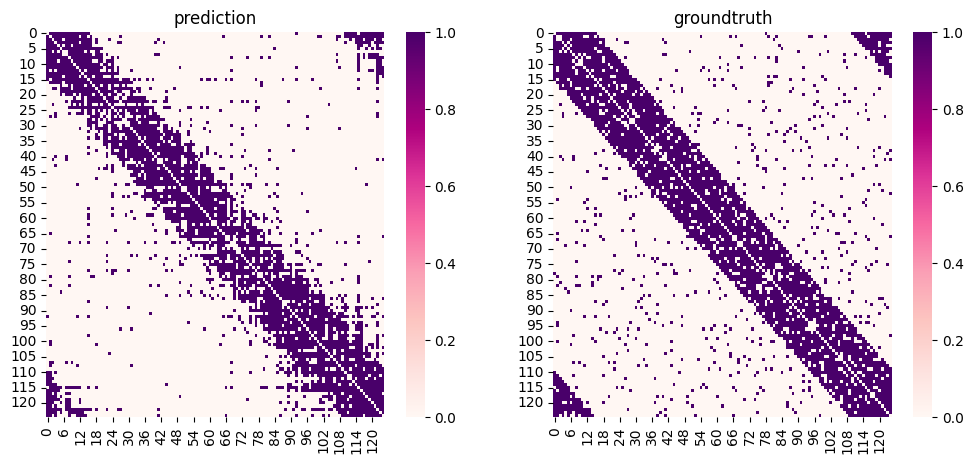

In [197]:
temp3 = [ [0]*graph_size for _ in range(graph_size) ]
temp4 = main_data['W'][index].toarray()

for i in range(graph_size):
    for j in range(i+1, graph_size):
        if adjacency_matrix[i][j]>=threshold:
            temp3[i][j]=1
            temp3[j][i]=1
        if temp4[i][j]>0:
            temp4[i][j]=1
            temp4[j][i]=1

fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
sns.heatmap(temp3, cmap = 'RdPu',  ax=axs[0])
axs[0].set_title('prediction')
sns.heatmap(temp4, cmap = 'RdPu', ax=axs[1])
axs[1].set_title('groundtruth')
plt.show()

## Preformance Evaluation

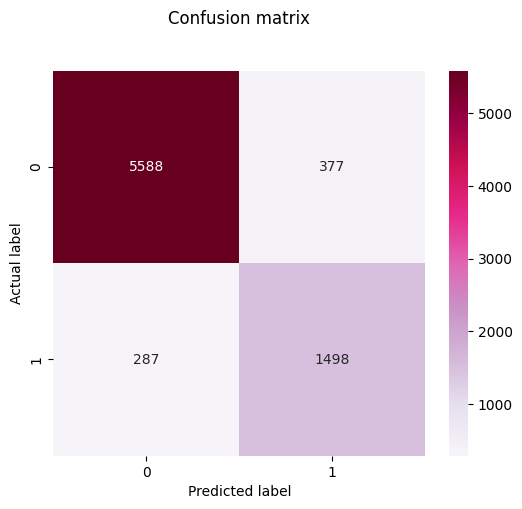

In [198]:
f, ax = plt.subplots(figsize=(6,5))
cm = confusion_matrix(squareform(temp3), squareform(temp4))
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="PuRd" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [199]:
TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
FP = cm[0][1]

FPP = FP/(FP+TN)
FNP = FN/(TP+FN)
Precision = TP/(TP+FP)
Recall = TP/(TP+FN)
Specificity = TN/(TN+FP)
F1 = (2*Precision*Recall)/(Precision+Recall)
ACC = (TP+TN)/(TP+FP+FN+TN)

print('False Positive Proportion: ', np.round(FPP, 4))
print('False Negative Proportion: ', np.round(FNP, 4))
print('Precision : \t', np.round(Precision, 4))
print('Recall: \t', np.round(Recall, 4))
print('Specificity : \t', np.round(Specificity, 4))
print('F1 Score: \t', np.round(F1, 4))
print('Accuracy: \t', np.round(ACC, 4))

False Positive Proportion:  0.0632
False Negative Proportion:  0.1608
Precision : 	 0.7989
Recall: 	 0.8392
Specificity : 	 0.9368
F1 Score: 	 0.8186
Accuracy: 	 0.9143


# Test 7 - ER 225

In [200]:
graph_size = 225

In [208]:
weight = 'gaussian'
main_data = generate_ER_parallel(num_samples=10,
                            num_signals=4000,
                            num_nodes=graph_size,
                            graph_hyper={'p':0.03},
                            weighted=weight,
                            weight_scale=True)

index = 2

***one data sample***

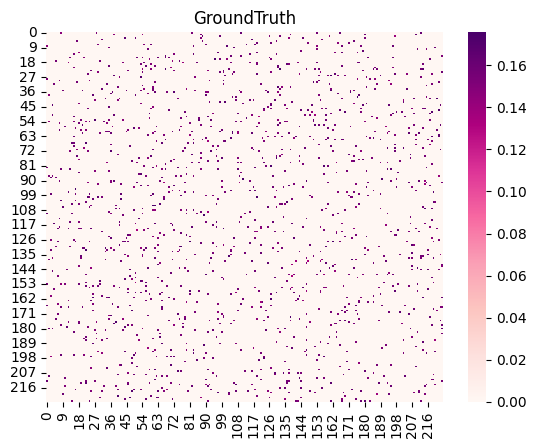

In [209]:
plt.figure()
sns.heatmap(main_data['W'][index].toarray(), cmap = 'RdPu')
plt.title('GroundTruth')
plt.show()

In [210]:
print('Number of Combinations {} out of {}:'.format(base_size ,graph_size))
print(nCr(graph_size,base_size))

Number of Combinations 10 out of 225:
74809092950832240


## K-combination Method

In [211]:
k = 2
print('Number of {}-Combinations {} out of {}:'.format(k, base_size, graph_size))
print(graph_size*(graph_size-1)//2*k)

Number of 2-Combinations 10 out of 225:
50400


In [212]:
threshold = 0.19225
adjacency_matrix = [ [0]*graph_size for _ in range(graph_size) ]
count_matrix = [ [0]*graph_size for _ in range(graph_size) ]
combinations = k_combinations(graph_size,base_size,k)
z_squareform = squareform(main_data['z'][index])

for comb in combinations:
    mini_combinations = list(itertools.combinations(comb, 2))
    new_z = []
    for minicomb in mini_combinations:
        new_z.append(z_squareform[minicomb[0]][minicomb[1]])
        count_matrix[minicomb[0]][minicomb[1]] += 1
        count_matrix[minicomb[1]][minicomb[0]] += 1

    new_z_tt = torch.tensor([new_z]).float().to(device)
    w_list = net.validation(new_z_tt , threshold=1e-04)
    w_pred = torch.clamp(w_list[:, - 1, :], min=0)[0].detach().cpu().numpy()

    for i, minicomb in enumerate(mini_combinations):
        adjacency_matrix[minicomb[0]][minicomb[1]] += w_pred[i]
        adjacency_matrix[minicomb[1]][minicomb[0]] += w_pred[i]

temp1 = [ [0]*graph_size for _ in range(graph_size) ]
temp2 = main_data['W'][index].toarray()

for i in range(graph_size):
    for j in range(i+1, graph_size):
        if count_matrix[i][j] is not 0:
            adjacency_matrix[i][j] /= count_matrix[i][j]
            adjacency_matrix[j][i] /= count_matrix[j][i]
        if adjacency_matrix[i][j]<threshold:
            temp1[i][j]=0
            temp1[j][i]=0
        else:
            temp1[i][j]=adjacency_matrix[i][j]
            temp1[j][i]=adjacency_matrix[j][i]

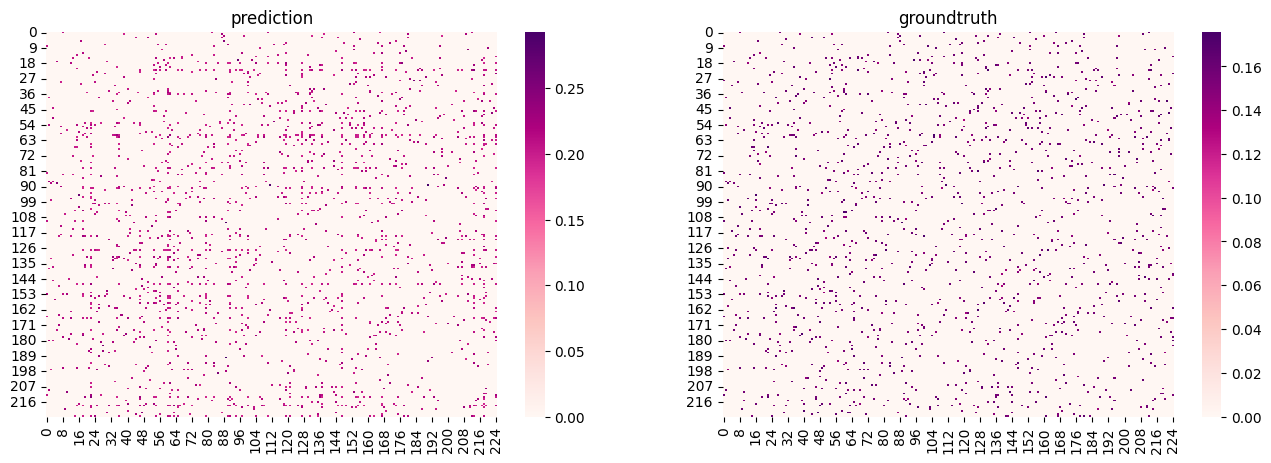

In [213]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 5))
sns.heatmap(temp1, cmap = 'RdPu',  ax=axs[0])
axs[0].set_title('prediction')
sns.heatmap(temp2, cmap = 'RdPu', ax=axs[1])
axs[1].set_title('groundtruth')
plt.show()

## Binarization

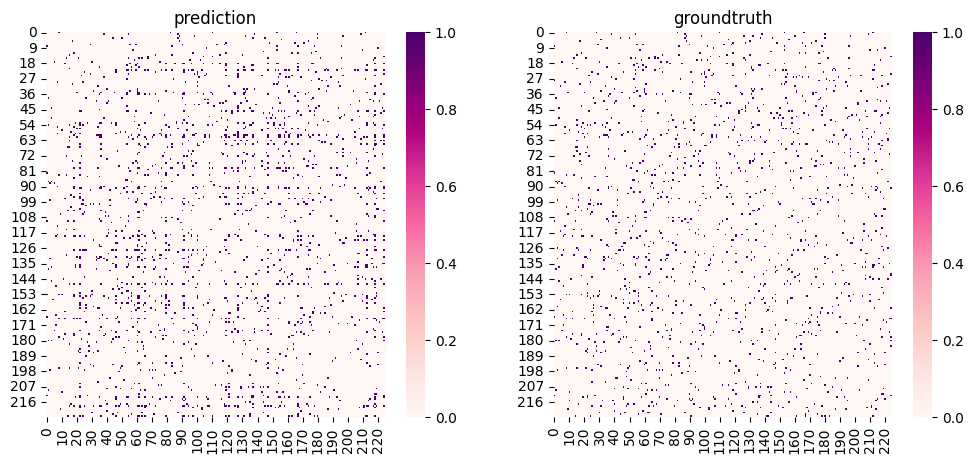

In [214]:
temp3 = [ [0]*graph_size for _ in range(graph_size) ]
temp4 = main_data['W'][index].toarray()

for i in range(graph_size):
    for j in range(i+1, graph_size):
        if adjacency_matrix[i][j]>=threshold:
            temp3[i][j]=1
            temp3[j][i]=1
        if temp4[i][j]>0:
            temp4[i][j]=1
            temp4[j][i]=1

fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
sns.heatmap(temp3, cmap = 'RdPu',  ax=axs[0])
axs[0].set_title('prediction')
sns.heatmap(temp4, cmap = 'RdPu', ax=axs[1])
axs[1].set_title('groundtruth')
plt.show()

## Preformance Evaluation

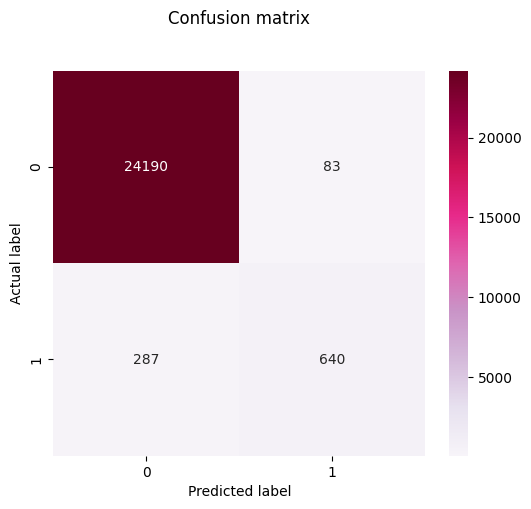

In [215]:
f, ax = plt.subplots(figsize=(6,5))
cm = confusion_matrix(squareform(temp3), squareform(temp4))
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="PuRd" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [216]:
TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
FP = cm[0][1]

FPP = FP/(FP+TN)
FNP = FN/(TP+FN)
Precision = TP/(TP+FP)
Recall = TP/(TP+FN)
Specificity = TN/(TN+FP)
F1 = (2*Precision*Recall)/(Precision+Recall)
ACC = (TP+TN)/(TP+FP+FN+TN)

print('False Positive Proportion: ', np.round(FPP, 4))
print('False Negative Proportion: ', np.round(FNP, 4))
print('Precision : \t', np.round(Precision, 4))
print('Recall: \t', np.round(Recall, 4))
print('Specificity : \t', np.round(Specificity, 4))
print('F1 Score: \t', np.round(F1, 4))
print('Accuracy: \t', np.round(ACC, 4))

False Positive Proportion:  0.0034
False Negative Proportion:  0.3096
Precision : 	 0.8852
Recall: 	 0.6904
Specificity : 	 0.9966
F1 Score: 	 0.7758
Accuracy: 	 0.9853
